## Cargamos las imagenes

In [1]:
!git clone https://github.com/arturotowers/Deep_learning.git

Cloning into 'Deep_learning'...
remote: Enumerating objects: 682, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 682 (delta 3), reused 5 (delta 1), pack-reused 666 (from 1)
Receiving objects: 100% (682/682), 42.64 MiB | 17.72 MiB/s, done.
Resolving deltas: 100% (25/25), done.


In [3]:
%cd Deep_learning

/content/Deep_learning


In [19]:
import os
import numpy as np

In [20]:
base_path = '/content/Deep_learning/Proyecto 1 - DAE + VAE/processed_dataset'
train_path = os.path.join(base_path, 'train')
val_path = os.path.join(base_path, 'val')
test_path = os.path.join(base_path, 'test')

In [21]:
def load_npy_from_folder(base_folder):
    images = []
    labels = []
    for class_name in os.listdir(base_folder):
        class_path = os.path.join(base_folder, class_name)
        if os.path.isdir(class_path):
            for file_name in os.listdir(class_path):
                file_path = os.path.join(class_path, file_name)
                if file_name.endswith('.npy'):
                    try:
                        img = np.load(file_path)
                        if isinstance(img, np.ndarray):
                            images.append(img)
                            labels.append(class_name)
                        else:
                            print(f"Archivo {file_path} no es un array numpy.")
                    except Exception as e:
                        print(f"Error al cargar {file_path}: {e}")
    return np.array(images), np.array(labels)

In [23]:
train_images, train_labels = load_npy_from_folder(train_path)
val_images, val_labels = load_npy_from_folder(val_path)
test_images, test_labels = load_npy_from_folder(test_path)

In [29]:
print(f"Train: {train_images.shape}, {train_labels.shape}")
print(f"Val: {val_images.shape}, {val_labels.shape}")
print(f"Test: {test_images.shape}, {test_labels.shape}")

Train: (138, 256, 256, 3), (138,)
Val: (30, 256, 256, 3), (30,)
Test: (30, 256, 256, 3), (30,)


Visualizamos una imagen para ver que todo haya salido bien

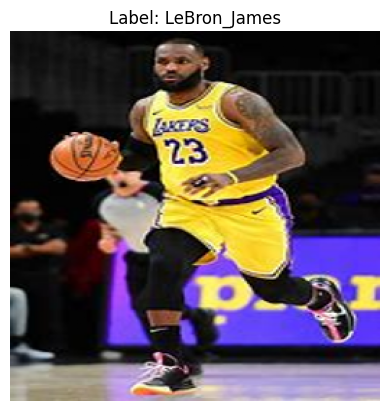

In [28]:
import matplotlib.pyplot as plt
image_index = 0
image = train_images[image_index]
label = train_labels[image_index]

# Muestra la imagen
plt.imshow(image)
plt.title(f'Label: {label}')
plt.axis('off')
plt.show()